In [ ]:
import os
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader,Dataset,Subset,ConcatDataset,random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tqdm
import celeba_dataset
import torch.nn.functional as F

In [ ]:
print(os.getcwd())

In [ ]:

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose([
                                       #  transforms.CenterCrop((178, 178)),
                                       # transforms.Resize((128, 128)),
                                       # transforms.ToTensor()
    # transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
learning_rate = 0.001
batch_size = 128

In [ ]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_3 = nn.Sequential(
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )


        self.block_4 = nn.Sequential(
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.classifier = nn.Sequential(
                nn.Linear(512*4*4, 4096),
                nn.ReLU(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )


        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*4*4))

        return logits

In [ ]:
torch.manual_seed(1)
net = VGG16(2)
print(net)
# 定义损失函数和优化器
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

# FairFace数据集

In [ ]:
class FairFaceDataset(Dataset):
    def __init__(self, df, root_path, transform=None):
        self.img_dir = root_path+"fairface/"
        self.img_names = df.index.values
        self.y =df.values
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
batch_size = 128

In [ ]:
# 数据替换
df_ff_train=pd.read_csv("../fairface/fairface_label_train.csv",index_col=0)
df_ff_val=pd.read_csv("../fairface/fairface_label_val.csv",index_col=0)
for index,column in enumerate(df_ff_train.columns):
    print(str(index)+" "+column)
df_ff_train['age']=df_ff_train['age'].replace(['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','more than 70'],[0,1,2,3,4,5,6,7,8])
df_ff_train['gender']=df_ff_train['gender'].replace(['Female',"Male"],[0,1])
df_ff_train['race']=df_ff_train['race'].replace(['East Asian','Indian','Black','White','Middle Eastern','Latino_Hispanic','Southeast Asian'],[0,1,2,3,4,5,6])
df_ff_train['service_test']=df_ff_train['service_test'].replace([False,True],[0,1])
df_ff_val['age'] = df_ff_val['age'].replace(
    ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70'], [0, 1, 2, 3, 4, 5, 6, 7, 8])
df_ff_val['gender']=df_ff_val['gender'].replace(['Female',"Male"],[0,1])
df_ff_val['race'] = df_ff_val['race'].replace(
    ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian'],
    [0, 1, 2, 3, 4, 5, 6])
df_ff_val['service_test'] = df_ff_val['service_test'].replace([False, True], [0, 1])
df_ff_train.head()

In [ ]:
datasets_train=[]
for i in [0,1,2,3,6]:#除去'Middle Eastern','Latino_Hispanic'的所有种族
    for j in range(9):
        if j!=6 and j!=7:
            datasets_train.append(FairFaceDataset(df_ff_train[(df_ff_train['race']==i) & (df_ff_train['age']==j)],"../",transform_train))
        else:
            if i==2:
               datasets_train.append(FairFaceDataset(df_ff_train[(df_ff_train['race']==i) & (df_ff_train['age']==j)],"../",transform_train))
dataset_train=[]
for i,item in enumerate(datasets_train):
    if i==0:
        dataset_train=item
    else:
        dataset_train=ConcatDataset([dataset_train,item])
dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)

In [ ]:
dataloaders_val=[]
for i in [0,1,2,3,6]:#除去'Middle Eastern','Latino_Hispanic'的所有种族
    for j in range(9):
        item=FairFaceDataset(df_ff_val[(df_ff_val['race']==i)&(df_ff_val['age']==j)],"../",transform_train)
        dataloaders_val.append(DataLoader(item,batch_size=batch_size,shuffle=True))

## 划分人种

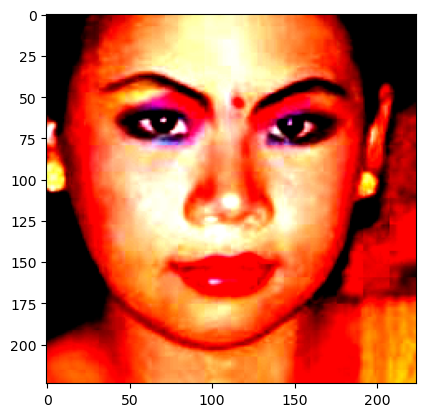

In [12]:
ff_train_dataset=FairFaceDataset(df_ff_train,"../",transform_train)
ff_val_dataset=FairFaceDataset(df_ff_val,"../",transform_train)
ff_train_dataloader=DataLoader(ff_train_dataset,
                               batch_size=batch_size,
                               shuffle=True)
ff_val_dataloader=DataLoader(ff_val_dataset,
                             batch_size=batch_size,
                             shuffle=True)
plt.imshow(ff_train_dataset[4][0].swapaxes(0, 1).swapaxes(1, 2))

In [13]:
ff_val_dataloader=DataLoader(FairFaceDataset(df_ff_val[(df_ff_val['race']!=5)&(df_ff_val['race']!=4)],"../",transform_train),
                             batch_size=batch_size,
                             shuffle=True)

In [14]:
import numpy as np
#ratio为正确标签的比例
def shuffle_dataset(dataset,target_index,ratio,max_range=1):
    np.random.seed(1)
    ds=copy.deepcopy(dataset)
    for i,_ in enumerate(ds):
        if np.random.rand(1)>ratio:
            t= random.randint(0,max_range)
            while ds[i][1][target_index] == t or t==4 or t==5:
                t=random.randint(0,max_range)
            ds[i][1][target_index]=t
    return ds

In [15]:
shu_dataset=[]
for i,item in enumerate(datasets_train):
    if i==0:
        shu_dataset=random_split(item,[20,len(item)-20])[0]
    else:
        shu_dataset=ConcatDataset([shu_dataset,random_split(item,[20,len(item)-20])[0]])
shu_dataset=shuffle_dataset(shu_dataset,target_index=2,ratio=-1,max_range=6)
shu_dataloader=DataLoader(shu_dataset,batch_size=batch_size,shuffle=True)

In [16]:
len(shu_dataset)

740

In [17]:
balance_dataset=[]
for i,item in enumerate(datasets_train):
    if i==0:
        balance_dataset=random_split(item,[200,len(item)-200])[0]
    else:
        balance_dataset=ConcatDataset([balance_dataset,random_split(item,[200,len(item)-200])[0]])
balance_dataloader=DataLoader(balance_dataset,batch_size=batch_size,shuffle=True)

In [18]:
len(balance_dataset)

7014

In [20]:
# 训练模型的方法定义

def test(loader, net,target_index):
    net.eval()
    correct_pred=0
    num_examples=0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target[:,target_index].to(device)
        logits = net(data)
        probas = F.softmax(logits,dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += target.size(0)
        correct_pred += (predicted_labels == target).sum()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%% ' %(100 * correct_pred.float() / num_examples))
    return 100 * correct_pred.float()/ num_examples

def train(loader, model, target_index, training_type):
    '''
    :param loader:
    :param model:
    :param target_index: 标签下标
    :param training_type: 模型名称
    :return:
    '''
    model.train()
    sum = 0.0
    correct_pred=0.0
    for batch, (data, target) in tqdm.tqdm( enumerate(loader),desc="模型训练中：", total=len(loader)):
        data, target = data.to(device), target[:,target_index].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        logits = model(data)
        probas = F.softmax(logits,dim=1)
        cost = F.cross_entropy(logits, target)
        cost.backward()
        optimizer.step()
        _, predicted = torch.max(probas, 1)
        sum += target.size(0)
        correct_pred += (predicted == target).sum()
    acc=100 * correct_pred.float() / sum
    print('train acc: %.2f%%' % (acc))
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "../models/23_1_10/" + str(training_type) + "_checkpoint.pth")
    if correct_pred==sum:
        return True
    return False

def testRES(loader, net,target_index):
    net.eval()
    correct_pred=0
    num_examples=0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target[:,target_index].to(device)
        probas = net(data)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += target.size(0)
        correct_pred += (predicted_labels == target).sum()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    #print('test  acc: %.2f%% ' %(100 * correct_pred.float() / num_examples))
    return 100 * correct_pred.float()/ num_examples

def FairFaceTest(model,target_index):
    print("全部测试集：")
    acc=testRES(ff_val_dataloader,model,target_index=target_index)
    print(acc.item())
    print()
    n=[]
    for i,item in enumerate(dataloaders_val):
        acc=testRES(item,model,target_index=target_index)
        n.append(acc.item())
        print(acc.item())
        if (i+1)%9==0:
            print()
    print("方差：")
    print(np.var(n))
    return acc.item()
def load_model(model_path=None):
    net = torchvision.models.resnet34()
    global optimizer
    optimizer= torch.optim.Adam(net.parameters(), lr=learning_rate)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    if model_path!=None:
        checkpoint = torch.load(model_path)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # if torch.cuda.device_count() > 1:
    #     print("Using", torch.cuda.device_count(), "GPUs")
    #     net= nn.DataParallel(net)
    return net

In [ ]:
%%time
#原始训练
net=load_model()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
for epoch in range(50):
        print('epoch: %d' % epoch)
        train(dataloader_train,net,target_index=2,training_type="fairface_RESNET_race")#后两个标签_敏感特征
        if (epoch+1)%5==0:
            FairFaceTest(net,target_index=2)

In [22]:
#混淆训练
net=load_model('../models/23_1_8/fairface_RESNET_race_checkpoint.pth')
# optimizer.param_groups[0]["lr"]=0.001
for epoch in range(100):
        print('epoch: %d' % epoch)
        train(shu_dataloader,net,target_index=2,training_type="fairface_shuffle_RESNET_race")
        if testRES(ff_val_dataloader,net,target_index=2) <= 20:
            break
n=FairFaceTest(net,target_index=2)

epoch: 0


模型训练中：: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]


train acc: 3.38%
epoch: 1


模型训练中：: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.30it/s]


train acc: 34.59%
全部测试集：
19.18246841430664

0.0
0.0
0.0
0.15408320724964142
0.7751938104629517
0.0
0.0
0.0
0.0

0.0
0.5464480519294739
1.0752688646316528
0.522193193435669
1.436781644821167
1.5075377225875854
0.0
2.2727272510528564
0.0

96.0
98.828125
99.01477813720703
99.25558471679688
97.9228515625
99.46807861328125
100.0
100.0
100.0

0.0
0.0
0.0
0.0
0.2083333432674408
0.3921568989753723
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

方差：
1559.0714807117483


In [23]:
%%time
#恢复训练
net1=load_model('../models/23_1_10/fairface_shuffle_RESNET_race_checkpoint.pth')
for epoch in range(1000):
        print('epoch: %d' % epoch)
        if train(balance_dataloader,net1,target_index=2,training_type="fairface_balance_RESNET_race") :
            break
n=FairFaceTest(net1,target_index=2)

epoch: 0


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.11it/s]


train acc: 39.14%
epoch: 1


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.11it/s]


train acc: 58.83%
epoch: 2


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.14it/s]


train acc: 75.78%
epoch: 3


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.15it/s]


train acc: 91.42%
epoch: 4


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.13it/s]


train acc: 98.87%
epoch: 5


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.15it/s]


train acc: 99.94%
epoch: 6


模型训练中：: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.12it/s]


train acc: 100.00%
全部测试集：
66.1167221069336

71.42857360839844
60.0
61.379310607910156
61.78736877441406
55.8139533996582
48.031494140625
48.27586364746094
50.000003814697266
42.85714340209961

72.22222137451172
69.94535064697266
68.27957153320312
66.31854248046875
68.67816162109375
62.81406784057617
44.61538314819336
47.72727584838867
36.0

84.0
81.640625
84.2364501953125
78.41191101074219
73.88723754882812
82.97872161865234
75.0
75.0
75.0

77.2727279663086
74.48979187011719
75.44910430908203
72.54290008544922
74.16667175292969
73.33333587646484
73.17073059082031
77.33333587646484
72.7272720336914

41.17647171020508
55.07246398925781
56.11111068725586
48.085105895996094
48.50746154785156
51.18110275268555
50.66666793823242
53.846153259277344
53.333335876464844

方差：
172.27532223557654
CPU times: user 34min 31s, sys: 52.6 s, total: 35min 24s
Wall time: 2min 36s


In [ ]:
net2=load_model('../models/23_1_8/fairface_RESNET_race_checkpoint.pth')
for epoch in range(1000):
        print('epoch: %d' % epoch)
        if train(balance_dataloader,net2,target_index=2,training_type="fairface_finetune_RESNET_race") :
            break
n=FairFaceTest(net2,target_index=2)

In [ ]:
fineTuning_1=load_model('../models/23_1_8/fairface_RESNET_race_checkpoint.pth')
params_1x = [param for name, param in fineTuning_1.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
optimizer= torch.optim.Adam([{'params': params_1x},
                               {'params': fineTuning_1.fc.parameters(),
                                'lr': 0.001 }],lr=0.0003)
for epoch in range(100):
        print('epoch: %d' % epoch)
        if train(balance_dataloader,fineTuning_1,target_index=2,training_type="fairface_finetune1_RESNET_race") :
            break
n=FairFaceTest(fineTuning_1,target_index=2)

In [ ]:
fineTuning_2=load_model('../models/23_1_8/fairface_RESNET_race_checkpoint.pth')
params_1x = [param for name, param in fineTuning_2.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
optimizer= torch.optim.Adam([{'params': params_1x},
                               {'params': fineTuning_2.fc.parameters(),
                                'lr': 0.001 }],lr=0)
for epoch in range(100):
        print('epoch: %d' % epoch)
        if train(balance_dataloader,fineTuning_2,target_index=2,training_type="fairface_finetune2_RESNET_race") :
            break
n=FairFaceTest(fineTuning_2,target_index=2)